In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

#Scikit-Learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

#Scikit-Survival
from sksurv.ensemble import RandomSurvivalForest, ExtraSurvivalTrees
from sksurv.svm import FastSurvivalSVM
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored

#Bayesian Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#eli5
import eli5
from eli5.sklearn import PermutationImportance

original_data = pd.read_csv('ver 2.00 for imputation_selected.csv')
original_data.drop(original_data[original_data.d_dimer_num_diagnosis.isnull()].index, inplace=True)

data = original_data.drop(columns=['Status'])
label = original_data[['Status']]

x_train, x_test, y_train, y_test = train_test_split(
    data, label, test_size=0.2, stratify=label, random_state=42
)

train_time = x_train.Surtime_day
test_time = x_test.Surtime_day

x_train = x_train.drop(columns=['Surtime_day'])
x_test = x_test.drop(columns=['Surtime_day'])

y_train['Surtime_day'] = train_time
y_test['Surtime_day'] = test_time

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

y_train = [(status, survtime) for status, survtime in y_train]
y_test = [(status, survtime) for status, survtime in y_test]

y_train = np.array(y_train, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
y_test = np.array(y_test, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [2]:
def cross_val_cindex(model, data, label, name=None):
    skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    features = data.copy()
    features = np.array(features)

    labels = label.copy()
    labels = np.array(labels)

    acc_list = []
    train_time_list = []
    test_time_list = []

    for train_idx, test_idx in skfold.split(features, labels):
        train_x, test_x = features[train_idx], features[test_idx]
    
        train_time = train_x[:, 3]
        test_time = test_x[:, 3]
    
        for time in train_time:
            train_time_list.append([time])
        for time in test_time:
            test_time_list.append([time])
    
        train_time = np.array(train_time_list)
        test_time = np.array(test_time_list)
    
        train_x = np.delete(train_x, 3, axis=1)
        test_x = np.delete(test_x, 3, axis=1)
    
        train_y, test_y = labels[train_idx], labels[test_idx]
    
        train_y = np.append(train_y, train_time, axis=1)
        test_y = np.append(test_y, test_time, axis=1)
    
        train_y = [(status, survtime) for status, survtime in train_y]
        test_y = [(status, survtime) for status, survtime in test_y]
    
        train_y = np.array(train_y, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
        test_y = np.array(test_y, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
    
        train_time_list.clear()
        test_time_list.clear()
    
        train_x = pd.DataFrame(data=train_x, columns=x_train.columns)
        test_x = pd.DataFrame(data=test_x, columns=x_test.columns)
    
        model.fit(train_x, train_y)
        acc_list.append(model.score(test_x, test_y))
    
    model_cindex = np.mean(acc_list)
    print(f'{name} Mean C-index : ', np.round(model_cindex, 4))

In [3]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['Status'], y['Survival_in_days'], prediction)
    return result[0]

In [6]:
rsf_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', RandomSurvivalForest(random_state=42))
])

extra_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', ExtraSurvivalTrees(random_state=42))
])

ridge_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', CoxPHSurvivalAnalysis(alpha=0.6))
])

svm_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', FastSurvivalSVM(random_state=42))
])

cross_val_cindex(model=rsf_pipe, data=data, label=label, name='Random Survival Forest')
cross_val_cindex(model=extra_pipe, data=data, label=label, name='ExtraTree')
cross_val_cindex(model=ridge_pipe, data=data, label=label, name='Ridge')
cross_val_cindex(model=svm_pipe, data=data, label=label, name='FastSVM')

Random Survival Forest Mean C-index :  0.5462
ExtraTree Mean C-index :  0.5545
Ridge Mean C-index :  0.6369
FastSVM Mean C-index :  0.6222


## Bayesian Optimization

#### Random Survival Forest

In [12]:
%%time
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search_space = {
    "bootstrap":Categorical([True, False]),
    "max_depth":Integer(6, 50),
    "max_features":Categorical(['auto', 'sqrt', 'log2']),
    "min_samples_leaf":Integer(2, 30),
    "min_samples_split":Integer(2, 30),
    "n_estimators":Integer(100, 1000)
    }

rsf_bayes_search = BayesSearchCV(estimator=RandomSurvivalForest(random_state=42), 
                                 search_spaces=search_space, scoring=score_survival_model,
                                 n_iter=100, n_jobs=-1, cv=skfold, verbose=0)
rsf_bayes_search.fit(x_train, y_train)

rsf_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', RandomSurvivalForest(**rsf_bayes_search.best_params_))
])

cross_val_cindex(model=rsf_pipe, data=data, label=label, name='Random Survival Forest')

Random Survival Forest Mean C-index :  0.5982
CPU times: user 24min 9s, sys: 35.4 s, total: 24min 44s
Wall time: 3min 25s


#### Ridge

In [13]:
%%time

search_space = {
    'alpha' : Real(0.1, 2.0),
    'ties' : Categorical(['breslow', 'efron']),
    'n_iter' : Integer(100, 1000),
    'tol' : Categorical([1e-7, 1e-8, 1e-9, 1e-10, 1e-11])
}

ridge_bayes_search = BayesSearchCV(estimator=CoxPHSurvivalAnalysis(),
                                  search_spaces=search_space, scoring=score_survival_model,
                                  n_iter=100, n_jobs=-1, cv=skfold, verbose=0).fit(x_train, y_train)
ridge_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', CoxPHSurvivalAnalysis(**ridge_bayes_search.best_params_))
])

cross_val_cindex(model=ridge_pipe, data=data, label=label, name='Ridge')

Ridge Mean C-index :  0.6406
CPU times: user 21min 14s, sys: 31.4 s, total: 21min 45s
Wall time: 2min 16s


#### Lasso

In [14]:
%%time 

search_space = {
    'l1_ratio' : Real(0.1, 1.0),
}

lasso_bayes_search = BayesSearchCV(estimator=CoxnetSurvivalAnalysis(alpha_min_ratio=0.01),
                                  search_spaces=search_space, scoring=score_survival_model,
                                  n_iter=100, n_jobs=-1, cv=skfold, verbose=0).fit(x_train, y_train)

lasso_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', CoxnetSurvivalAnalysis(**lasso_bayes_search.best_params_))
])

cross_val_cindex(model=lasso_pipe, data=data, label=label, name='Lasso')

Lasso Mean C-index :  0.6277
CPU times: user 16min 22s, sys: 25 s, total: 16min 47s
Wall time: 1min 43s


#### ExtraTree

In [15]:
%%time

search_space = {
    "bootstrap":Categorical([True, False]),
    "max_depth":Integer(6, 50),
    "max_features":Categorical(['auto', 'sqrt', 'log2']),
    "min_samples_leaf":Integer(2, 30),
    "min_samples_split":Integer(2, 30),
    "n_estimators":Integer(100, 1000)
    }

extra_bayes_search = BayesSearchCV(estimator=ExtraSurvivalTrees(random_state=42), 
                                 search_spaces=search_space, scoring=score_survival_model,
                                 n_iter=100, n_jobs=-1, cv=skfold, verbose=0)
extra_bayes_search.fit(x_train, y_train)

extra_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', ExtraSurvivalTrees(**extra_bayes_search.best_params_))
])

cross_val_cindex(model=extra_pipe, data=data, label=label, name='ExtraTree')

ExtraTree Mean C-index :  0.5758
CPU times: user 25min 11s, sys: 35.9 s, total: 25min 47s
Wall time: 3min 2s


In [19]:
perm = PermutationImportance(rsf_pipe, scoring=score_survival_model, n_iter=200, random_state=42)
perm.fit(x_test, y_test)

print('##Random Survival Forest Importance')
eli5.show_weights(perm, feature_names=x_train.columns.tolist())

##Random Survival Forest Importance


Weight,Feature
0.0764 ± 0.0592,HbA1c
0.0412 ± 0.0408,d_dimer_num_diagnosis
0.0248 ± 0.0341,Age
0.0230 ± 0.0224,Homocysteine
0.0185 ± 0.0176,RoPE_score_5_scale
0.0141 ± 0.0222,oldest_d_dimer_num
0.0107 ± 0.0180,Valsalva
0.0102 ± 0.0192,Hb_diagnosis
0.0100 ± 0.0139,CRP_diagnosis
0.0099 ± 0.0173,RoPE_score


In [20]:
perm = PermutationImportance(ridge_pipe, scoring=score_survival_model, n_iter=200, random_state=42)
perm.fit(x_test, y_test)

print('##Ridge Importance')
eli5.show_weights(perm, feature_names=x_train.columns.tolist())

##Ridge Importance


Weight,Feature
0.1556 ± 0.0625,oldest_d_dimer_num
0.1062 ± 0.1277,LDL
0.0777 ± 0.0860,Chol
0.0770 ± 0.0356,d_dimer_num_diagnosis
0.0445 ± 0.0526,RoPE_score
0.0360 ± 0.0557,Plt_diagnosis
0.0222 ± 0.0304,RoPE_score_5_scale
0.0154 ± 0.0330,Age
0.0141 ± 0.0345,CRP_diagnosis
0.0140 ± 0.0268,alcohol


In [21]:
perm = PermutationImportance(extra_pipe, scoring=score_survival_model, n_iter=200, random_state=42)
perm.fit(x_test, y_test)

print('##ExtraTree Importance')
eli5.show_weights(perm, feature_names=x_train.columns.tolist())

##ExtraTree Importance


Weight,Feature
0.0141 ± 0.0290,composite_coagulopathy
0.0121 ± 0.0258,RoPE_score_5_scale
0.0087 ± 0.0268,RoPE_score
0.0049 ± 0.0112,oldest_d_dimer_num
0.0030 ± 0.0110,HTN
0.0030 ± 0.0407,Sex
0.0026 ± 0.0107,HbA1c
0.0020 ± 0.0115,Valsalva
0.0013 ± 0.0053,TG
0.0011 ± 0.0181,LDL


In [22]:
perm = PermutationImportance(svm_pipe, scoring=score_survival_model, n_iter=200, random_state=42)
perm.fit(x_test, y_test)

print('##FastSVM Importance')
eli5.show_weights(perm, feature_names=x_train.columns.tolist())

##FastSVM Importance


Weight,Feature
0.1969 ± 0.1072,RoPE_score
0.1468 ± 0.0472,oldest_d_dimer_num
0.1325 ± 0.0375,d_dimer_num_diagnosis
0.0590 ± 0.1007,LDL
0.0507 ± 0.0670,alcohol
0.0440 ± 0.0488,Chol
0.0217 ± 0.0339,Plt_diagnosis
0.0213 ± 0.0206,Cancer
0.0209 ± 0.0202,Cancer.1
0.0196 ± 0.0192,RoPE_score_5_scale


## Shap Value

Permutation explainer: 70it [00:20,  1.78it/s]                                                                                        


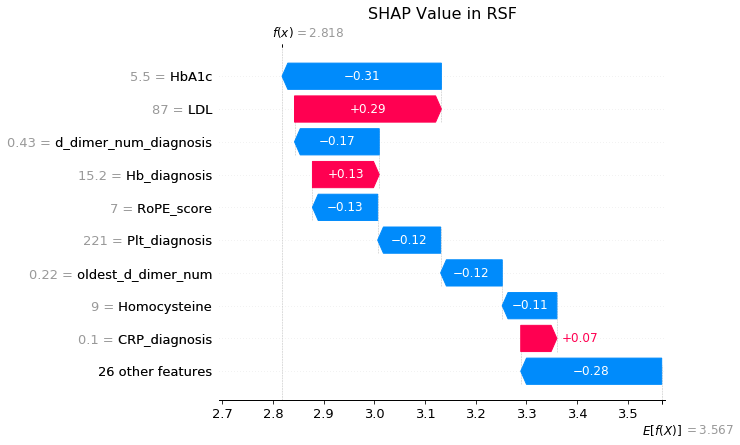

In [25]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(rsf_pipe.predict, x_train, feature_names=data.columns)
shaps = explainer(x_test)
plt.title('SHAP Value in RSF', fontsize=16)
shap.plots.waterfall(shaps[0])

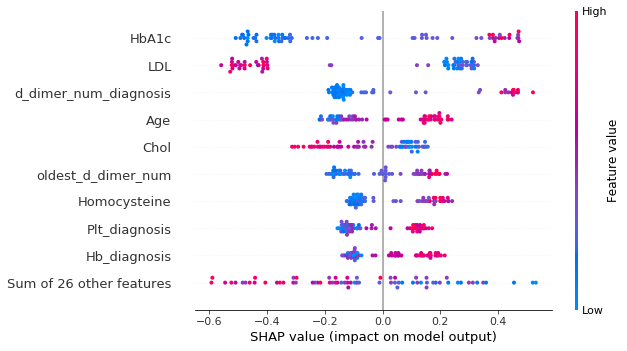

In [28]:
shap.plots.beeswarm(shaps)

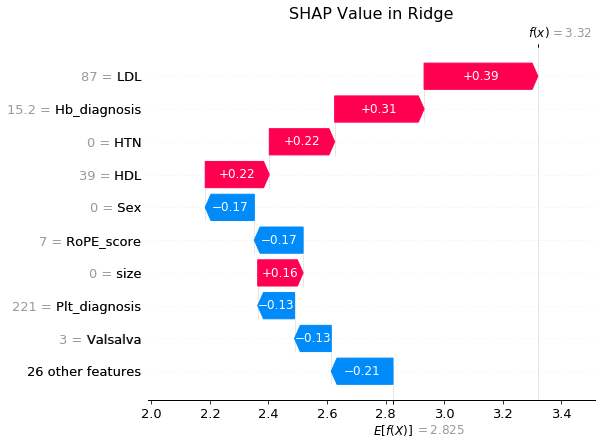

In [17]:
explainer = shap.Explainer(ridge_pipe.predict, x_train, feature_names=data.columns)
shaps = explainer(x_test)
plt.title('SHAP Value in Ridge', fontsize=16)
shap.plots.waterfall(shaps[0])

Permutation explainer: 70it [00:19,  1.75it/s]                                                                                        


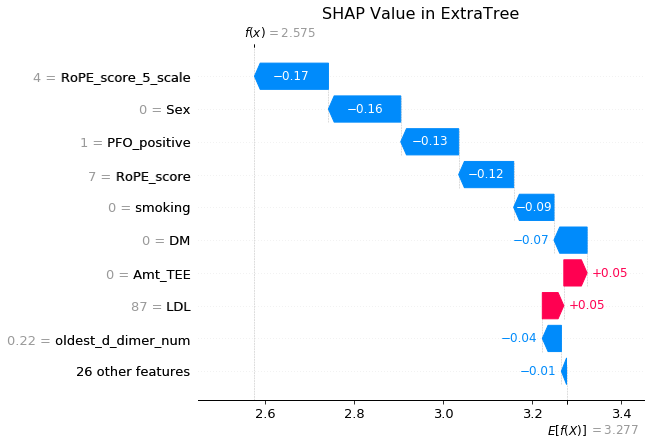

In [18]:
explainer = shap.Explainer(extra_pipe.predict, x_train, feature_names=data.columns)
shaps = explainer(x_test)
plt.title('SHAP Value in ExtraTree', fontsize=16)
shap.plots.waterfall(shaps[0])

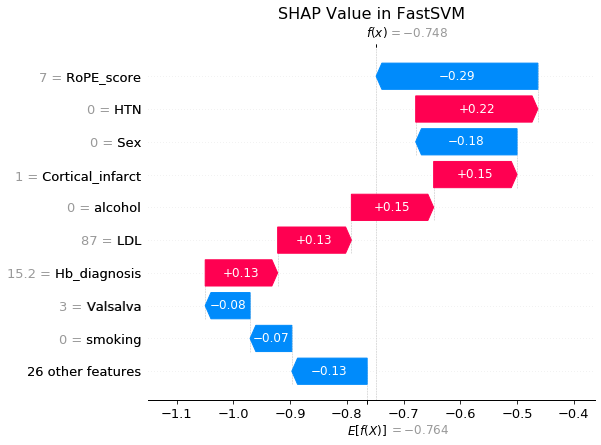

In [24]:
explainer = shap.Explainer(svm_pipe.predict, x_train, feature_names=data.columns, seed=42)
shaps = explainer(x_test)
plt.title('SHAP Value in FastSVM', fontsize=16)
shap.plots.waterfall(shaps[0])